# 1. Importing Libraries

In [2887]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, plot_confusion_matrix, PrecisionRecallDisplay, auc, make_scorer
from statsmodels.stats.diagnostic import lilliefors
import math
from feature_engine import transformation as vt
from matplotlib.colors import ListedColormap
from boruta import BorutaPy
from sklearn import tree
import plotly.express as px

# 2. Reading Data

In [2775]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df



def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#for the testing purporse, trim to remain first 100 rows only
X = read_features()
y = read_target().iloc[:,0]

In [2776]:
#Row & Columns of Features 
X.shape

(1567, 590)

# 3. Splitting Training & Testing Data

In [2777]:
#Splitting the Data: 80% Training, 20% Testing Data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

In [2778]:
#Rows and Columns of X_Train DF
x_train.shape

(1253, 590)

In [2779]:
#Rows and Columns of X_Train DF
x_test.shape

(314, 590)

# 4. Reducing Dimensionality

## 4.1. Remove duplicated Columns

In [2780]:
#Function for finding and removing duplicated columns (features)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

In [2781]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_duplicated_columns(x_train)
x_train.shape

(1253, 486)

## 4.2. Removing Features with Constant Volatility

In [2782]:
#Defining function to find and remove features with zero standard deviation 
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

In [2783]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_constant_volatility(x_train)
x_train.shape

(1253, 474)

## 4.3. Remove Features with high % of Missing Values

In [2784]:
#Defining function to remove features with a given % of missing values 
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

In [2785]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_cols_with_high_pct_null(x_train, 0.7)
x_train.shape

(1253, 466)

# 5. Outlier & Missing Value Treatment

In [2786]:
#Definition of Functiom
def outlier_clamp(df):
    for col in df.columns:
        ll_col = df[col].mean() - 2 * df[col].std()
        ul_col = df[col].mean() + 2 * df[col].std()
        df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

In [2787]:
x_train = outlier_clamp(x_train)

In [2788]:
#KNN only distance
def knndistance(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation 
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [2789]:
x_train = knndistance(x_train)

In [2790]:
#Function to drop Outliers and impute Missing Values with KNN 
def outlierknn(df):
    #Outlier treatment first:
    for col in df.columns:
          ll_col = df[col].mean() - 3 * df[col].std()
          ul_col = df[col].mean() + 3 * df[col].std()
          df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
    #Scaling data 
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [2791]:
#Using function above on x_train
#x_train = outlierknn(x_train)

# 6. Feature Selection

In [2792]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [2793]:
#Using Boruta Shap on x_train
x_train = BorutaShap_FS(x_train,y_train,'shap')

  0%|          | 0/100 [00:00<?, ?it/s]

In [2794]:
#RFE

#classifier = ['RF', 'SVM']

def RFE_FS (X, y,classify) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    if classify == 'RF':
    # define random forest classifier
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    if classify== 'SVM':
        model = SVC(kernel='linear',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 30)
    rfe.fit(X_scaled,y)

     # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [2795]:
#Using RFE on x_train
#x_train = RFE_FS(x_train, y_train, 'RF')

In [2796]:
#Boruta function with random forest

def BorutaPy_FS (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    ##--feature_selector.support_

    # check ranking of features
    ##--feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    # feature_ranks = list(zip(feature_names, 
    #                          feature_selector.ranking_, 
    #                          feature_selector.support_))

    # print the results
    ##--for feat in feature_ranks:
    ##--    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 2) #change to 2
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    ##--print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features))

In [2797]:
#Using BorutaPy_FS on x_train
#x_train = BorutaPy_FS(x_train, y_train)

In [2798]:
#Shape of x_train after Feature Selection
x_train.shape

(1253, 18)

Text(0.5, 1.0, 'Correlation of remaining Features')

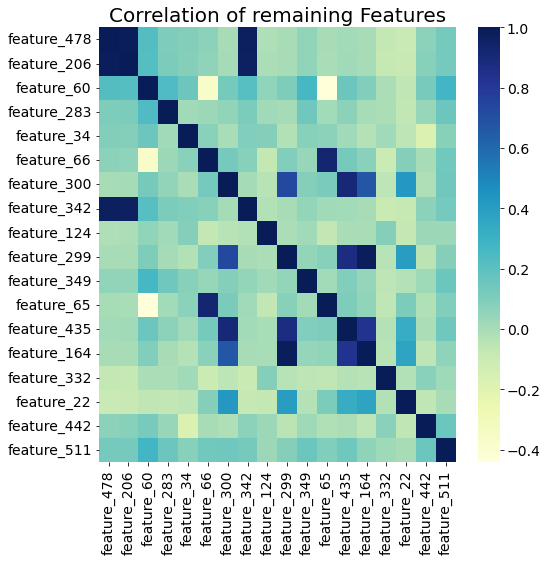

In [2799]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 7. Multicolinearity Treatment

In [2800]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):


    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [2801]:
x_train=remove_collinear_features(x_train, 0.7)
x_train.shape

(1253, 12)

Text(0.5, 1.0, 'Correlation of remaining Features')

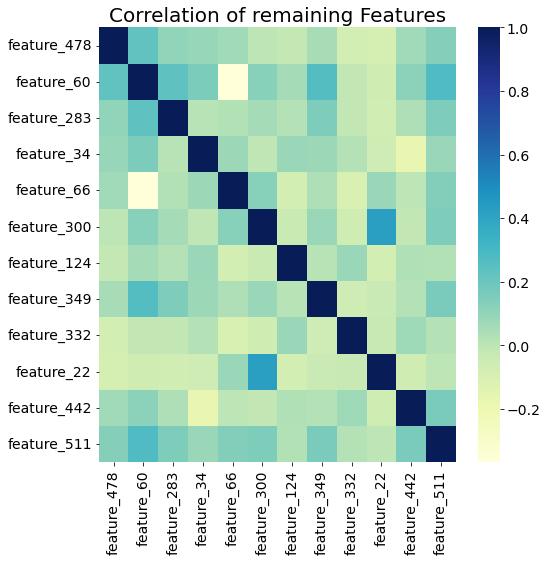

In [2802]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

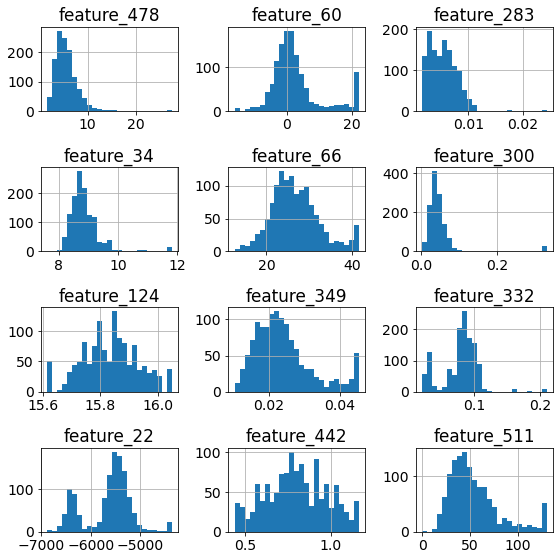

In [2803]:
#Histograms remaining Features 
x_train.hist(bins=25)
plt.tight_layout()
plt.show()

In [2804]:
#Normality Test
for i in x_train.columns:
    print(i)
    statistic, pvalue = lilliefors(x_train[[i]])
    print('statistic=%.3f, p=%.3f\n' % (statistic, pvalue))
    if pvalue > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')

feature_478
statistic=0.118, p=0.001

Probably not Gaussian
feature_60
statistic=0.170, p=0.001

Probably not Gaussian
feature_283
statistic=0.074, p=0.001

Probably not Gaussian
feature_34
statistic=0.142, p=0.001

Probably not Gaussian
feature_66
statistic=0.055, p=0.001

Probably not Gaussian
feature_300
statistic=0.241, p=0.001

Probably not Gaussian
feature_124
statistic=0.045, p=0.001

Probably not Gaussian
feature_349
statistic=0.102, p=0.001

Probably not Gaussian
feature_332
statistic=0.157, p=0.001

Probably not Gaussian
feature_22
statistic=0.150, p=0.001

Probably not Gaussian
feature_442
statistic=0.037, p=0.001

Probably not Gaussian
feature_511
statistic=0.112, p=0.001

Probably not Gaussian


# 8. Balancing

In [2805]:
#Function SMOTEENN
def sampling(X_train, y_train):
    sampler = SMOTEENN(random_state=100)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

In [2806]:
x_train, y_train = sampling(x_train, y_train)

In [2807]:
x_train.shape

(1593, 12)

In [2808]:
y_train.shape

(1593,)

In [2809]:
y_train.value_counts()

 1    907
-1    686
Name: status, dtype: int64

# 9. Modeling

In [2810]:
#Turning y_train to categorical, since Naive Bayes works better on categorical data
y_train = pd.Categorical(y_train)
y_train = pd.DataFrame(y_train)

In [2811]:
#Model and Model Evaluation
gnb = GaussianNB()
gnb.fit(x_train, y_train)
# make predictions
expected = y_train
predicted = gnb.predict(x_train)
# summarize the fit of the gnb
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


              precision    recall  f1-score   support

          -1       0.62      0.88      0.73       686
           1       0.87      0.60      0.71       907

    accuracy                           0.72      1593
   macro avg       0.75      0.74      0.72      1593
weighted avg       0.76      0.72      0.72      1593

[[604  82]
 [365 542]]


In [2812]:
#Sensitivity of Model
cf_matrix = confusion_matrix(expected, predicted)
sensitivity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
sensitivity

0.597574421168688

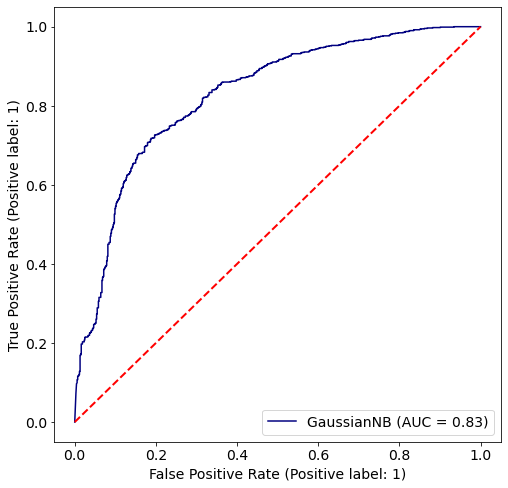

In [2813]:
# ROC curve Train Data 
metrics.RocCurveDisplay.from_estimator(gnb, x_train, y_train, color="navy")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.show()

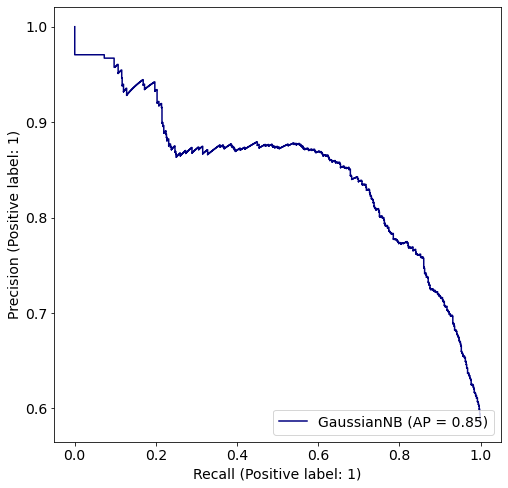

In [2814]:
#Precision / Recall Train Data
metrics.PrecisionRecallDisplay.from_estimator(gnb, x_train, y_train, color="navy")
plt.legend(loc="lower right")
plt.show()

# 10. Test Data

In [2815]:
#1. Remove Duplicated Columns 
x_test = remove_duplicated_columns(x_test)
x_test.shape

(314, 480)

In [2816]:
#2. Remove Constant Volalitily
x_test = remove_constant_volatility(x_test)
x_test.shape

(314, 468)

In [2817]:
#3. Remove High % of NA
x_test = remove_cols_with_high_pct_null(x_test, 0.7)
x_test.shape

(314, 460)

In [2818]:
#4. Treat Outliers and Missing Values
## IF NA + KNN
#x_test= outlierknn(x_test)
## IF CLAMP + KNN
x_test = outlier_clamp(x_test)
x_test = knndistance(x_test)

In [2819]:
#5. Take the same Columns as in train data 
columns_list = x_train.columns
x_test = x_test.loc[:,columns_list]
x_test.shape

(314, 12)

In [2820]:
#6. Change Target Variable to Categorical
y_test = pd.Categorical(y_test)
y_test = pd.DataFrame(y_test)

In [2821]:
y_test.value_counts()

-1    293
1      21
dtype: int64

In [2822]:
exp_test = y_test
pred_test = gnb.predict(x_test)
# summarize the fit of the gnb
print(metrics.classification_report(exp_test, pred_test))
print(metrics.confusion_matrix(exp_test, pred_test))

              precision    recall  f1-score   support

          -1       0.96      0.83      0.89       293
           1       0.18      0.52      0.27        21

    accuracy                           0.81       314
   macro avg       0.57      0.68      0.58       314
weighted avg       0.91      0.81      0.85       314

[[243  50]
 [ 10  11]]


In [2823]:
cf_matrix_test = confusion_matrix(exp_test, pred_test)
sensitivity_test = cf_matrix_test[1][1] / ( cf_matrix_test[1][1] + cf_matrix_test[1][0] )
sensitivity_test

0.5238095238095238

In [2824]:
#Accuracy score
accuracy_score(exp_test, pred_test)

0.8089171974522293

In [2825]:
#Recall score
recall_score(exp_test, pred_test)

0.5238095238095238

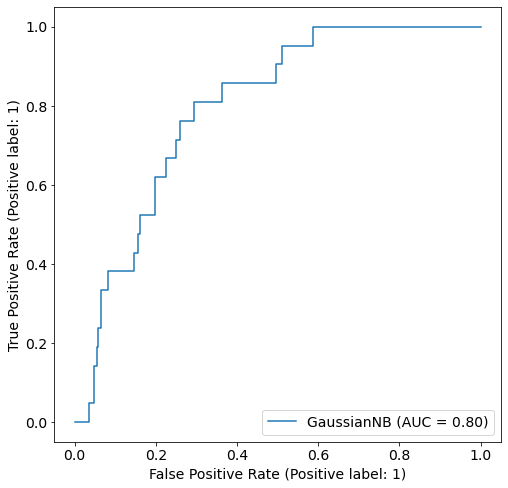

In [2826]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(gnb, x_test, y_test)
plt.show()

# 11. Grid Search & Cross Validation

## 11.1. Grid Search

In [2997]:
#Gridsearch
##Define Grid Search Parameters 
scoring = {"Accuracy": make_scorer(accuracy_score), "Recall" : make_scorer(recall_score), "Auc": make_scorer(roc_auc_score)}
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
#cv = StratifiedKFold(n_splits=5)
#Hyperparameter Tune using Training Data 
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10,  n_jobs=-1, scoring="roc_auc") #Best Sofar 
#nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10,  n_jobs=-1, scoring=scoring, refit="Auc")
nbModel_grid.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validatio

GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.848035...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc', verbose=1)

In [2998]:
#Print Best estimator
print(nbModel_grid.best_estimator_, "is the best estimator")

GaussianNB(var_smoothing=2.848035868435799e-05) is the best estimator


In [2999]:
#Data Frame Grid Search Results 
gridsearchNB = pd.DataFrame(nbModel_grid.cv_results_)
gridsearchNB.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006481,0.002971,0.004203,0.002103,1.0,{'var_smoothing': 1.0},0.589584,0.725434,0.693104,0.654750,0.623994,0.731884,0.664027,0.672915,0.619910,0.675986,0.665159,0.043136,100
1,0.001619,0.000086,0.001974,0.000078,0.811131,{'var_smoothing': 0.8111308307896871},0.590221,0.725593,0.693104,0.655072,0.624316,0.732367,0.664189,0.673077,0.620556,0.676147,0.665464,0.043022,99
2,0.001641,0.000142,0.001979,0.000063,0.657933,{'var_smoothing': 0.657933224657568},0.590540,0.726071,0.693104,0.655233,0.624799,0.732528,0.664350,0.672754,0.620394,0.676147,0.665592,0.043019,98
3,0.001753,0.000204,0.002069,0.000140,0.53367,{'var_smoothing': 0.533669923120631},0.590540,0.727027,0.692945,0.655556,0.625443,0.733655,0.664189,0.672915,0.620718,0.675986,0.665897,0.043217,97
4,0.001578,0.000141,0.002045,0.000180,0.432876,{'var_smoothing': 0.43287612810830584},0.591018,0.727504,0.692785,0.656039,0.626248,0.733655,0.664512,0.673077,0.621202,0.676471,0.666251,0.043067,96


In [3000]:
gridsearchNB.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_var_smoothing', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

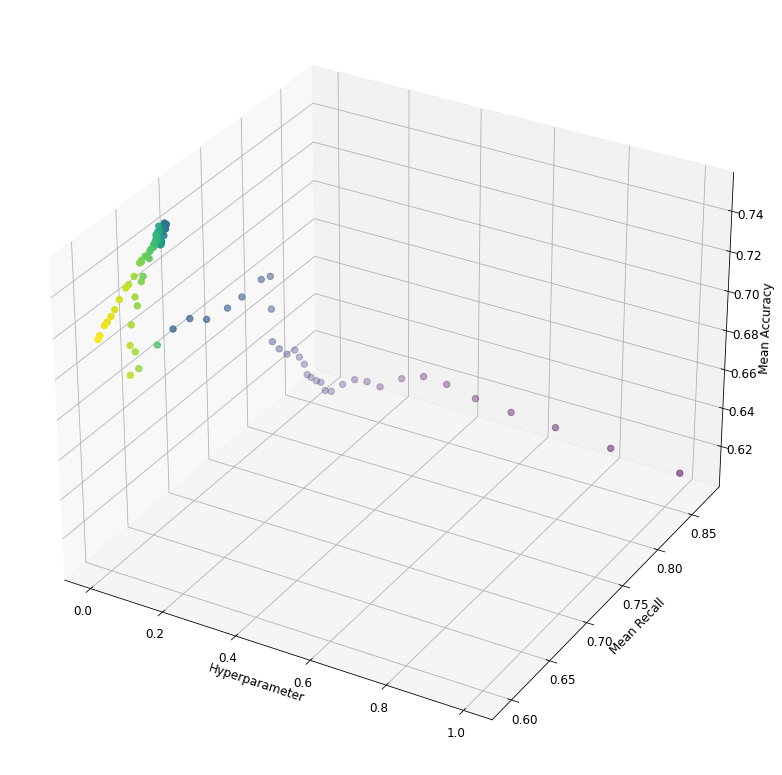

In [2992]:
fig = plt.figure(figsize=(16, 14))
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(projection='3d')

x,z,y = gridsearchNB.param_var_smoothing, gridsearchNB.mean_test_Accuracy, gridsearchNB.mean_test_Recall
ax.set_xlabel('Hyperparameter')
ax.set_ylabel('Mean Recall')
ax.set_zlabel('Mean Accuracy')
ax.scatter(x,y,z, cmap='viridis', marker='o', s=40, c=gridsearchNB.rank_test_Recall)
plt.show()

<AxesSubplot:xlabel='mean_test_score', ylabel='param_var_smoothing'>

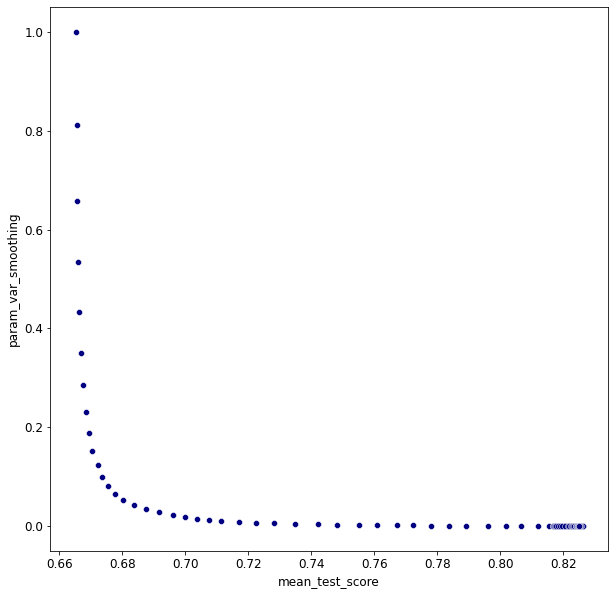

In [3001]:
#Gridsearch Vizualization
sns.scatterplot(data=gridsearchNB, y='param_var_smoothing', x='mean_test_score', color="navy")

## 11.2. Cross Validation

In [3010]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=20)
print("mean Recall")
scores = cross_val_score(nbModel_grid.best_estimator_, x_train, y_train, cv=cv, scoring = 'recall')
print(scores.mean())
print("mean accuracy")
accuracycv = cross_val_score(nbModel_grid.best_estimator_, x_train, y_train, cv=cv, scoring = 'accuracy') 
print(accuracycv.mean())
# fit
nb=nbModel_grid.best_estimator_.fit(x_train, y_train)    
# predict
y_pred_test = nb.predict(x_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)
# View accuracy score
RecallFinal = recall_score(y_test, y_pred_test)
print('Test Recall : ', RecallFinal)

mean Recall
0.6662077294685991
mean accuracy
0.7458148734177217
Test Accuracy :  0.7802547770700637
Test Recall :  0.7142857142857143


In [3006]:
scores_df = pd.DataFrame(scores, columns=['recall_scores'])
acc_df = pd.DataFrame(accuracycv, columns=['accuracy_scores'])
cv_scores_df = pd.concat([scores_df, acc_df], axis=1)
cv_scores_df

,recall_scores,accuracy_scores
0,0.622222,0.737500
1,0.644444,0.762500
2,0.711111,0.750000
3,0.666667,0.775000
4,0.666667,0.750000
5,0.688889,0.762500
6,0.673913,0.775000
7,0.630435,0.725000
8,0.673913,0.712500
9,0.608696,0.675000


<AxesSubplot:xlabel='recall_scores', ylabel='accuracy_scores'>

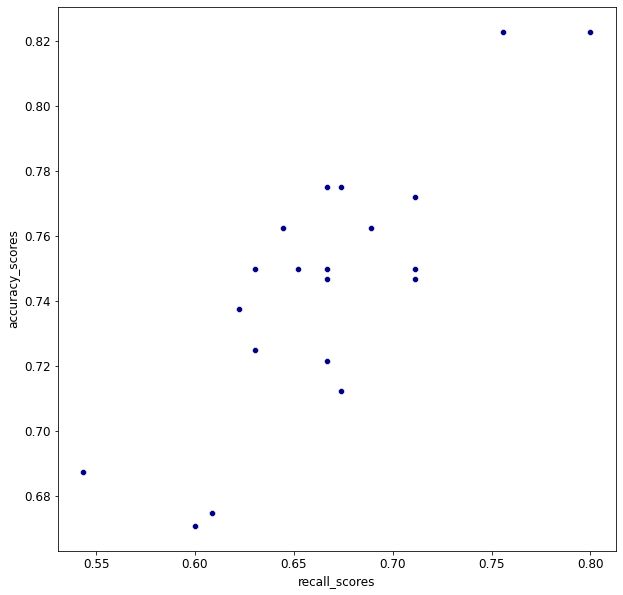

In [3007]:
#Crossvalidation Vizualization
sns.scatterplot(data=cv_scores_df, x='recall_scores', y='accuracy_scores', color="navy")

In [3008]:
#Confusion Matrix & Classification Report of best estimator
print(metrics.confusion_matrix(y_test, y_pred_test))
print(metrics.classification_report(y_test, y_pred_test))

[[230  63]
 [  6  15]]
              precision    recall  f1-score   support

          -1       0.97      0.78      0.87       293
           1       0.19      0.71      0.30        21

    accuracy                           0.78       314
   macro avg       0.58      0.75      0.59       314
weighted avg       0.92      0.78      0.83       314



In [2980]:
precision_score(y_test, y_pred_test)

0.1875

In [2941]:
recall_score(y_test, y_pred_test)

0.7142857142857143

In [2952]:
roc_auc_score(y_test, y_pred_test)

0.7462213554363726

In [2943]:
auc = roc_auc_score(y_test, y_pred_test)
GINI = (2 * auc) - 1
print(GINI)

0.49244271087274516


In [2944]:
f1_score(y_test, y_pred_test)

0.297029702970297

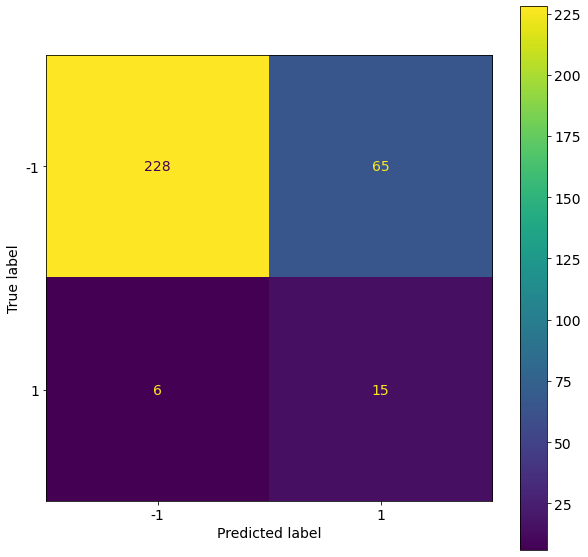

In [2945]:
# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=nbModel_grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nbModel_grid.best_estimator_.classes_)
disp.plot()
plt.show()

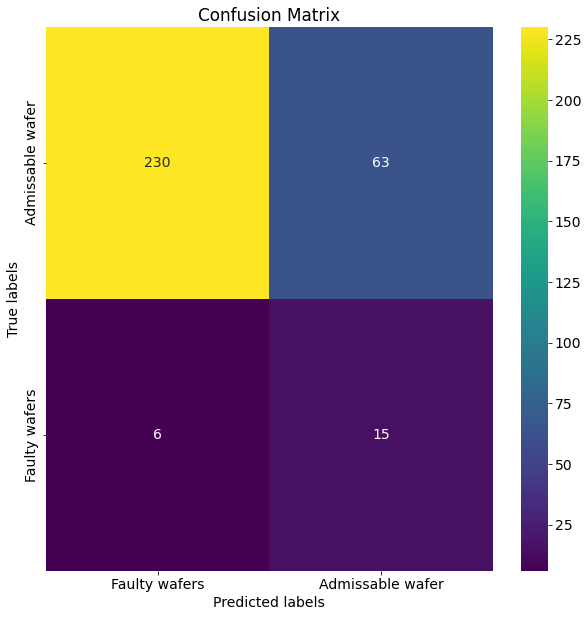

In [2897]:
ax= plt.subplot()
plt.rcParams['figure.figsize'] = (8, 10)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='viridis')  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Faulty wafers', 'Admissable wafer']); ax.yaxis.set_ticklabels(['Admissable wafer', 'Faulty wafers',]); 

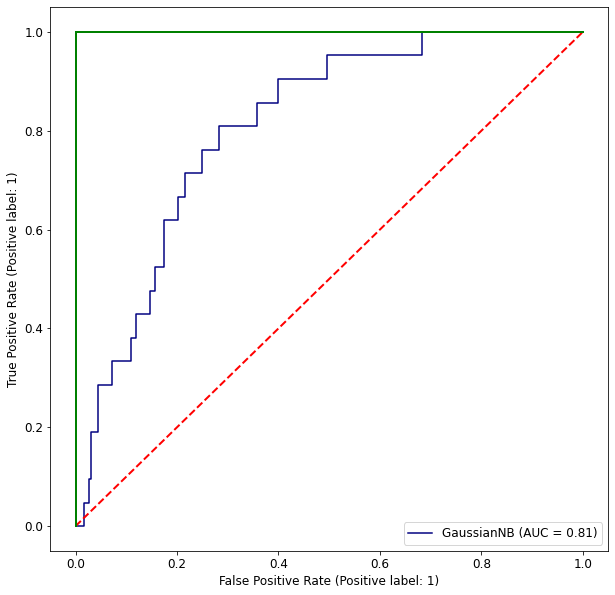

In [3011]:
# ROC curve
plt.rcParams['figure.figsize'] = (10, 10)
metrics.RocCurveDisplay.from_estimator(nbModel_grid.best_estimator_, x_test, y_test, color="navy")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.plot([0, 0], [1, 0], color="green", lw=2, linestyle="-")
plt.plot([1, 0], [1, 1], color="green", lw=2, linestyle="-")
plt.show()

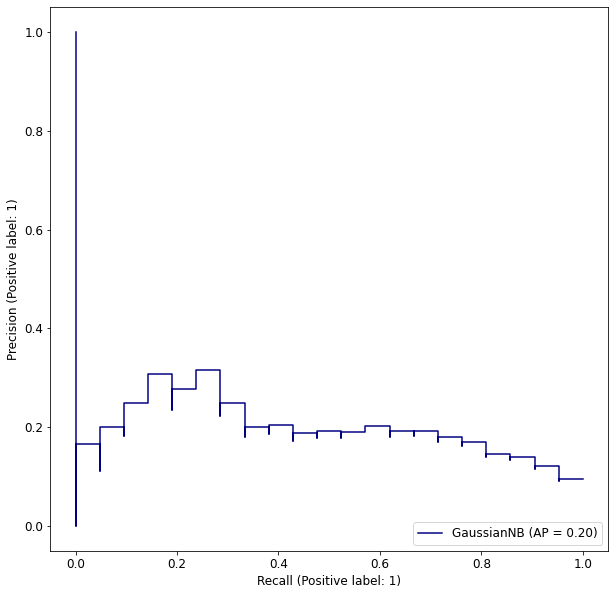

In [3012]:
#Precision / Recall
metrics.PrecisionRecallDisplay.from_estimator(nbModel_grid.best_estimator_, x_test, y_test, color="navy")
plt.legend(loc="lower right")
plt.show()

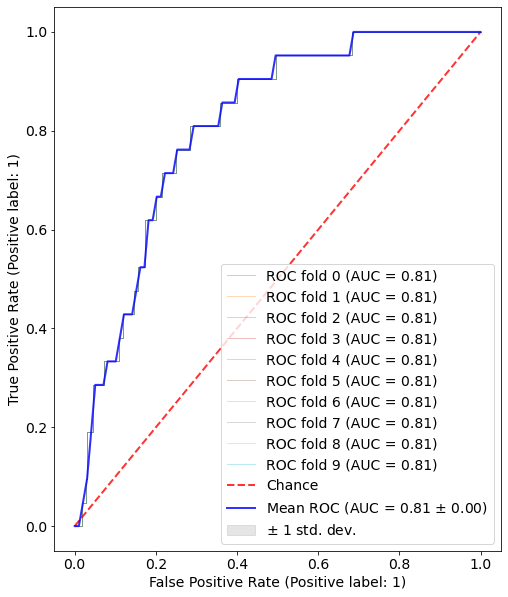

In [2900]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(x_train, y_train)):
    nbModel_grid.best_estimator_.fit(x_train, y_train)
    viz = metrics.RocCurveDisplay.from_estimator(
        nbModel_grid.best_estimator_,
        x_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05]
)
ax.legend(loc="lower right")
plt.show()    